# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [132]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')



In [133]:
# add any additional libaries you need here



In [134]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [136]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [137]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [138]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


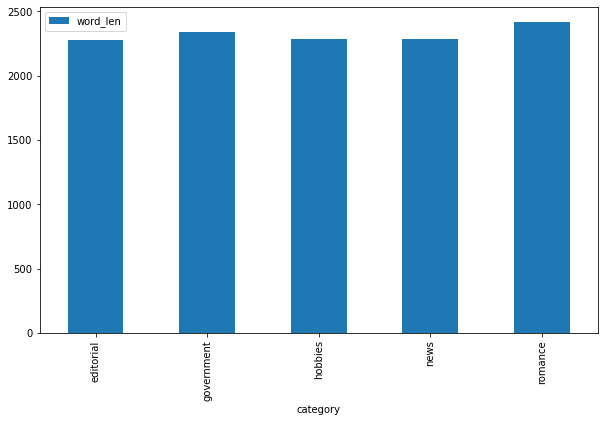

In [139]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6));

Now do our TF-IDF and Count vectorizations.

In [140]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\victor-pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [141]:
feat_names = count_text_vectorizer.get_feature_names_out()

df_count_text = pd.DataFrame.sparse.from_spmatrix(count_text_vectors, columns=feat_names)

# df_count_text

In [142]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

C:\Users\victor-pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count_text_vectors holds the word frequency in each document, tfidf_text_vectors hold the word importance scaled, TF-IDF (Term Frequency - Inverse Document Frecuency) combining count vectorizer with importance given to more frequent terms, however it adds another calculation where it scales down the importance as well because not always the most frequent word is the most important one in a document 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [143]:
nmf_text_model = NMF(n_components=5, random_state=314)

W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)

H_text_matrix = nmf_text_model.components_

C:\Users\victor-pc\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [144]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [146]:
# The W Matrix holds the topics as the columns and the documents as rows
# we can use this to combine it with the original dataframe that has the category and id

w_matrix_df = pd.DataFrame(W_text_matrix)
w_matrix_df["category"] = df["category"]
w_matrix_df["id"] = df["id"]


topic_dictionary = dict()

topic_dictionary = {0 : {},
                    1 : {},
                    2 : {},
                    3 : {},
                    4 : {}}

# Looping over the dataframe (using .iterrows())
for index, row in w_matrix_df.iterrows():
    
    # in order to get the Topic we extract the first 5 values of each row
    # then using .argsort() we find the indexes based on size of each value
    # then we inverse sort from highest to lowest
    # and the document topic is the first of the highest --> largest value is the Topic that document belongs to
    document_topic = np.array(row.iloc[0:5]).argsort()[::-1][0]
    
    # now that we access to that doc category, we can just select it
    document_category = row['category'] 
    
    # building the dictionary
    if document_category in topic_dictionary[document_topic]:
        topic_dictionary[document_topic][document_category] += 1
    else:
        topic_dictionary[document_topic][document_category] = 1


# once dictionary is created, we loop over it to get
# the print out of how many categories per Topic
for key, dictionary_value in topic_dictionary.items():
    
    print(f"\nTopic {key}:")
    
    for category in dictionary_value:
        
        print(f"  {dictionary_value[category]} {category}") 
        
        


Topic 0:
  20 editorial
  4 government
  8 news

Topic 1:
  4 editorial
  29 romance
  8 hobbies

Topic 2:
  2 editorial
  26 government
  11 news
  26 hobbies

Topic 3:
  17 news
  1 hobbies

Topic 4:
  1 editorial
  8 news
  1 hobbies


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMF model does well in Topic 0 (Editorial (20)) , Topic 1 (Romance (29)) and Topic 3 (News (17)) where a specific category has most number of occurrences. As for Topic 2 the model has an even number of occurrences for Government and Hobbies, where clearly Topic 2 should've been Government only  and Topic 4 Hobbies.


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [147]:
# Your code here

svd_para_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [148]:
# tallying the Brown categories

w_svd_matrix_df = pd.DataFrame(W_svd_para_matrix)
w_svd_matrix_df["category"] = df["category"]
w_svd_matrix_df["id"] = df["id"]
                       
topic_dictionary = dict()

topic_dictionary = {0 : {}, 1 : {}, 2 : {}, 3 : {}, 4 : {}}

for index, row in w_svd_matrix_df.iterrows():
    document_topic = np.array(row.iloc[0:5]).argsort()[::-1][0]
    document_category = row['category'] 

    if document_category in topic_dictionary[document_topic]:
        topic_dictionary[document_topic][document_category] += 1
    else:
        topic_dictionary[document_topic][document_category] = 1

for key, dictionary_value in topic_dictionary.items():
    print(f"\nTopic {key}:")
    for category in dictionary_value:
        print(f"  {dictionary_value[category]} {category}") 
        


Topic 0:
  27 editorial
  30 government
  34 news
  21 romance
  36 hobbies

Topic 1:
  8 romance

Topic 2:

Topic 3:
  3 news

Topic 4:
  7 news


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: For TruncatedSVD almost all categories are being assigned to Topic 0 and does not do well splitting the categories into 5 groups / topics. With Topic 2 not being assigned any of the documents. 

In [149]:
# call display_topics on your model
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Topic 04's top-words are hobby-related words, but the W-matrix produced by the SVD model assigns the highest value to Topic 01 in general. After further inspection by running the display_topics with 20 top_words (instead of 5) we can see some small but important differences in the words select by SVD vs NMF, with the government-related word "krushchev" appearing in the SVD model as one of the top words for Topic 04. This deviation is probably what is changing the total weight given to Hobbies category documents.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [150]:
# Fit your LDA model here

lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

In [151]:
# Call `display_topics` on your fitted model here
display_topics(lda_para_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [152]:
# tallying the Brown categories

w_lda_matrix_df = pd.DataFrame(W_lda_para_matrix)
w_lda_matrix_df["category"] = df["category"]
w_lda_matrix_df["id"] = df["id"]
                       
topic_dictionary = dict()

topic_dictionary = {0 : {}, 1 : {}, 2 : {}, 3 : {}, 4 : {}}

for index, row in w_lda_matrix_df.iterrows():
    document_topic = np.array(row.iloc[0:5]).argsort()[::-1][0]
    document_category = row['category'] 

    if document_category in topic_dictionary[document_topic]:
        topic_dictionary[document_topic][document_category] += 1
    else:
        topic_dictionary[document_topic][document_category] = 1

for key, dictionary_value in topic_dictionary.items():
    print(f"\nTopic {key}:")
    for category in dictionary_value:
        print(f"  {dictionary_value[category]} {category}") 



Topic 0:
  3 editorial
  1 government
  4 news
  28 romance
  11 hobbies

Topic 1:
  1 editorial
  12 government
  3 news
  9 hobbies

Topic 2:
  21 editorial
  3 government
  32 news
  1 romance
  2 hobbies

Topic 3:
  2 editorial
  4 government
  3 news
  8 hobbies

Topic 4:
  10 government
  2 news
  6 hobbies


Q: What inference do you draw from the displayed topics for your LDA model? 

A: When switching to CountVectorizer instead of TF-IDF Vectorizer the model is giving a bigger informative value to only term frequency, making terms such as "000" appear as top-words in some the created topics by the LDA model. This is a drawback of not using TF-IDF. The hobby-related words do not seem to appear as much in any of the created topics

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 has more occurrences of the "romance" category, but the category "government" is the occuring the most in two topics (Topic 1 and Topic 4). Another not clearly defined topic is Topic 2 where editorial and news appear very often. And finally Topic 3 has the most occurrences of the Hobbies category, but almost non of the top_20 words are hobby-related words, so it's not clear it this Topic is clearly defined as Hobbies

In [154]:
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\victor-pc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\victor-pc\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [155]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: PCA scatter plot shows the four clusters (topics) with Topic 4 (which would correspond to the previously displayed Topic 3) having its top 30 Saliency ranking as mostly education-related words.  This type of visualizations helps us gained a more clear understanding of undiscovered topics in our dataset, and that Education topic is an example of that.
